<a href="https://colab.research.google.com/github/marco-sorich/SeasonalityChartAnalysis/blob/main/Seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Seasonality

_Notebook for analysis of seasonality of one symbol_


In [119]:
# ! pip install yfinance
# check also https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr


### Choose symbol and choose its data


In [120]:
symbol='2B7K.DE'   # iShares MSCI World SRI UCITS ETF EUR (Acc)
#symbol='EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)

yf.pdr_override() # <== that's all it takes :-)
df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2019-03-27,4.6245
2019-03-28,4.6245
2019-03-29,4.6245
2019-04-01,4.6245
2019-04-02,4.6245


### Show daily closing price and moving average

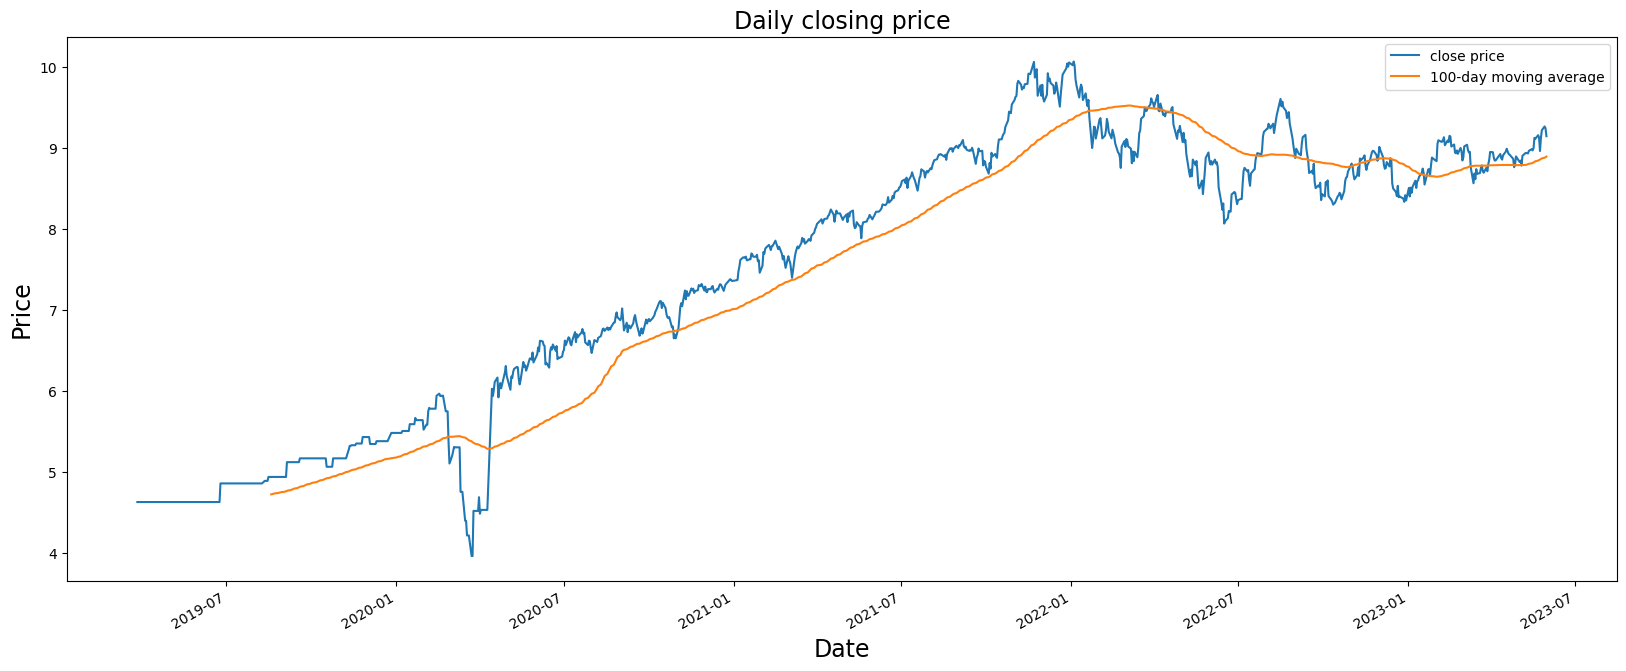

In [121]:
rolling_resolution = 100

plt.figure(figsize=(20,8))
plt.xlabel('Data', fontsize=17)
plt.ylabel('Price', fontsize=17)
plt.title('Daily closing price', fontsize=17)
#plt.grid(b=True, which='major', color='b', linestyle='-')

df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average')
#df[symbol].plot(legend=True, label='20-day VWAP')

plt.show()

### Get seasonality from data

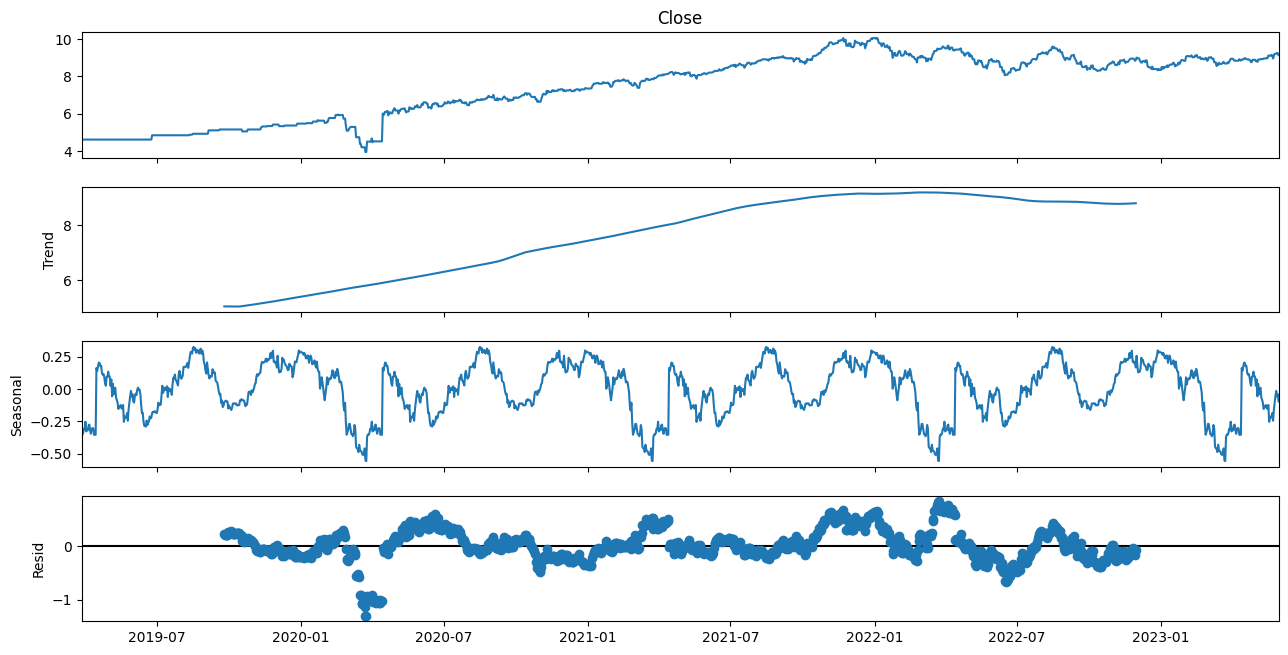

In [140]:


df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

decompose = seasonal_decompose(df['Close'], model='additive', period=365)
fig = decompose.plot()
fig.tight_layout()
fig.set_size_inches(14,7)

